In [1]:
import os
import string
from datetime import datetime, timedelta
from enum import Enum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as mcolors
from test_case_utils import WeatherParams, TestCase, TargetCases, MlflowConfig, get_artifact_path

In [2]:
MlflowConfig.train_run_ids

{'rain_only': 'e94dd1a35e984d618310a2b9cbbb5602',
 'rain_temp_humid': '2e2c64a1723b462d9ec0f8ad37e3ce03',
 'rain_winds': '2924c119f2f649bfa724fa937a65bfb0',
 'all': 'a06a7107eecf4d6e851ab27653d5d7e7'}

In [3]:
train_metrics = pd.DataFrame()
for key, run_id in MlflowConfig.train_run_ids.items():
    train_metrics_file = os.path.join(get_artifact_path(run_id), run_id, 'artifacts', 'training_metrics.csv')
    df = pd.read_csv(train_metrics_file)
    df.rename(columns={'Unnamed: 0': 'x'}, inplace=True)
    # for col in ['train_loss', 'valid_loss', 'valid_acc']:
    #     df[col] = df[col].apply(np.log)
    df['hue'] = key
    train_metrics = pd.concat([train_metrics, df], axis=0)

In [4]:
train_metrics.head()

,x,train_loss,valid_loss,valid_acc,hue
0,0,0.064038,0.072278,0.040680,rain_only
1,1,0.059236,0.075387,0.049438,rain_only
2,2,0.059105,0.070508,0.034594,rain_only
3,3,0.058964,0.073636,0.041208,rain_only
4,4,0.058796,0.072214,0.033485,rain_only


dict_keys(['rain_only', 'rain_temp_humid', 'rain_winds', 'all'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


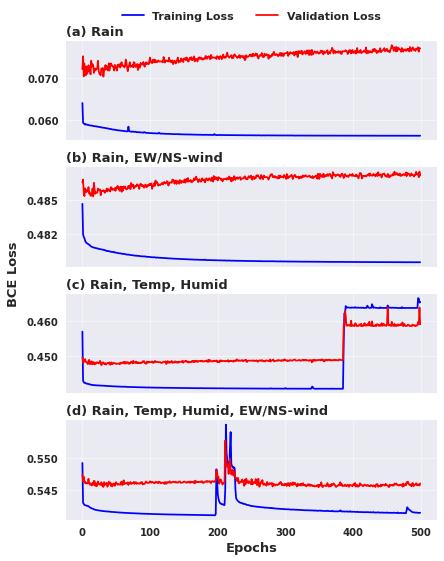

In [5]:
print(MlflowConfig.train_run_ids.keys())
# Training loss
plt.style.use('seaborn')
fig, axes = plt.subplots(4, 1, figsize=(6, 9))
axes = axes.flatten()
labels = [
    'Rain',
    'Rain, EW/NS-wind',
    'Rain, Temp, Humid',
    'Rain, Temp, Humid, EW/NS-wind'
]
yticks = [
    [0.070, 0.060],
    [0.485, 0.482],
    [0.46, 0.45],
    [0.550, 0.545]
]
for idx, key in enumerate(['rain_only', 'rain_winds', 'rain_temp_humid', 'all']):
    # fig, ax = plt.subplots(figsize=(8, 6))
    ax = axes[idx]
    training_losses = train_metrics.loc[train_metrics.hue == key]
    # train_loss, valid_loss = training_losses.train_loss.copy(), training_losses.valid_loss.copy()
    # training_losses['train_loss'] = train_loss / train_loss.loc[0]
    # training_losses['valid_loss'] = valid_loss / valid_loss.loc[0]
    sns.lineplot(data=training_losses, x='x', y='train_loss', ax=ax, color='blue')
    sns.lineplot(data=training_losses, x='x', y='valid_loss', ax=ax, color='red'c)

    if idx == 0:
        ax.legend(
            ['Training Loss', 'Validation Loss'],
            prop={'size': 11, 'weight': 'bold'},
            loc='upper center', ncol=2,
            bbox_to_anchor=(0.5, 1.4)
        )

    ax.grid(alpha=0.5)
    if idx != 3:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Epochs', fontweight='bold', fontsize=13, y=0.9)
        for obj in ax.get_xticklabels():
            obj.set_fontweight('bold')
    ax.set_title(f'({string.ascii_lowercase[idx]}) {labels[idx]}', loc='left', weight='bold', size=13)
    ax.set_yticks(yticks[idx])
    ax.set_ylabel('')
    for obj in ax.get_yticklabels():
        obj.set_fontweight('bold')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
fig.suptitle('BCE Loss', ha='left', va='center', x=-0.02, y=0.45, rotation=90, fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('learning-curve-plot.eps', format='eps', bbox_inches='tight')
plt.show()
plt.close()